# Hybrid Quantum Support Vector Machine Classifier Example
The following example details a possible implementation of a hybrid support vector classifier applied on the iris dataset.

An SVM convex optimization problem can be reformulated into a system of linear equations in the form $Ax= b$, the solution of which is a trained SVM model:
\begin{align*}
\begin{bmatrix}
0 & 1^T_M \\
1_M & K+\gamma^{-1}I_M
\end{bmatrix}
\begin{bmatrix}
\beta \\
\alpha
\end{bmatrix} =
\begin{bmatrix}
0 \\
Y
\end{bmatrix}
\end{align*}
with $M$ number of training samples, $K=K(x_i,x_j)$ kernel matrix, $X$ training set, $Y$ classification labels, $\gamma$ regularization hyperparameter, $1_M = [1,...1]^T$, $I_M$ identity matrix, $\alpha$ and $\beta$ respectively weights and bias used in prediction.
Model prediction on new data can be obtained as
\begin{align*}
f(\cdot) = K( \cdot,X) \cdot \alpha + \beta
\end{align*}

Building $A$ requires computing the kernel matrix $K$ of distances from each sample to each sample, which is done in a quantum fashion, and solving the system requires a matrix inversion.

In [22]:
# TODO: uncomment the next line after release qlearnkit 0.2.0
#!pip install qlearnkit
!pip install matplotlib

  Using cached matplotlib-3.5.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached kiwisolver-1.4.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached fonttools-4.32.0-py3-none-any.whl (900 kB)


In [23]:
import numpy as np
from qlearnkit.algorithms.qsvm import QSVClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from qiskit import BasicAer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.utils import QuantumInstance

Let's first prepare our data.

In [24]:
# import some data to play with
iris = load_iris()
mms = MinMaxScaler()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
X = mms.fit_transform(X)
y = iris.target

Now Let's prepare the feature map we are going to use, along with the backend we will run the simulation on.

In [25]:
seed = 42
encoding_map = PauliFeatureMap(2)
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   shots=1024,
                                   optimization_level=1,
                                   seed_simulator=seed,
                                   seed_transpiler=seed)

Let's create our quantum SVC from qlearnkit along with a classical SVC for comparison.

In [26]:
svc = SVC(kernel='linear')
qsvc = QSVClassifier(encoding_map=encoding_map, quantum_instance=quantum_instance)

Now we can train our hybrid-quantum model

In [27]:
svc.fit(X,y)
qsvc.fit(X,y)

And finally we plot the decision boundaries of the two algorithms and see how they perform

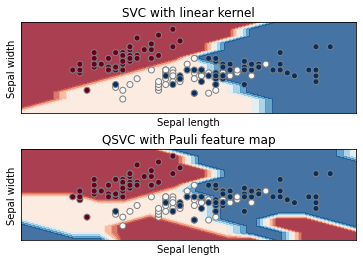

In [28]:
h = 0.1 # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'QSVC with Pauli feature map']

for i, clf in enumerate((svc, qsvc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 1, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap="RdBu", alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu",edgecolor="grey" )
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

Notice how the quantum boundary is nonlinear. This is a consequence of the Pauli feature map we used. Different settings and different feature maps give different results.

In case you want to try with a different backend simulator you could also install `pennylane-qiskit` and play around with `qiskit.aer` or `qiskit.qasm`.

Be aware that it's gonna be way slower because of qiskit simulators.
